Imports & Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import requests
import os

seed = 42

download = True	# Flag to download or create the graph from local file
graph_url = "https://github.com/SorenLKuhl/imdb_network/raw/refs/heads/main/imdb_movie_network.pkl"

We load the tsv containing the movies of interest.

In [24]:
if download:
	print("Do nothing for now - download graph from GitHub later")
else:
	path = "../datasets/final_filtered_movies.tsv"
	movies_df = pd.read_csv(path, sep="\t")
	print(f"Number of movies: {len(movies_df)}")
	movies_df.head()

Do nothing for now - download graph from GitHub later


Now we create an undirected networkx graph with the movies as nodes and actors as links. We save the accompanying data as attributes on the nodes.

In [25]:
if download:
	# Download the pickled graph from GitHub
	response = requests.get(graph_url)
	response.raise_for_status()  # Ensure we got a successful response
	G = pickle.loads(response.content)
else:
	G: nx.Graph = nx.Graph()	# Undirected as links are actors in common

	# Create mapping of actors to movies
	actor_to_movies = {}

	for idx, row in movies_df.iterrows():

		# Add movie as node with attributes
		id = row['tconst']
		title = row['primaryTitle']
		original_title = row['originalTitle']
		avg_rating = row['averageRating']
		num_ratings = row['numVotes']
		actors = row['actors'].split(', ')
		G.add_node(id, title=title, original_title=original_title, avg_rating=avg_rating, num_ratings=num_ratings)

		# Map actors to movies
		for actor in actors:
			if actor not in actor_to_movies:
				actor_to_movies[actor] = []
			actor_to_movies[actor].append(id)

	# Add edges based on shared actors
	for actor, movies in actor_to_movies.items():
		for i in range(len(movies)):
			for j in range(i + 1, len(movies)):
				G.add_edge(movies[i], movies[j], actor=actor)

# Display basic info about the graph - should have num of node = num of movies
print(G)

Graph with 2638 nodes and 72826 edges


To ensure the mapping works as intended, we check the movies that are linked by Leonardo DiCaprio to see if the list is as expected.

In [26]:
test_name = "Leonardo DiCaprio"
linked_movies = set()
for movie1, movie2, data in G.edges(data=True):
	if data['actor'] == test_name:
		linked_movies.add(G.nodes[movie1]['title'])
		linked_movies.add(G.nodes[movie2]['title'])
print(f"Movies linked by {test_name}: {linked_movies}")

Movies linked by Leonardo DiCaprio: {'Inception', 'Titanic', 'The Departed', 'The Wolf of Wall Street'}


Pickle G to upload to GitHub for easy download from other devices.

In [27]:
if not download:
	pickle_path = "imdb_movie_network.pkl"
	with open(pickle_path, 'wb') as f:
		pickle.dump(G, f)

We see that only 4 movies are found, which makes sense as the "actors" field of the data is created from the actor's "known for" movies on imdb which is max 4.

We now visualize the graph:

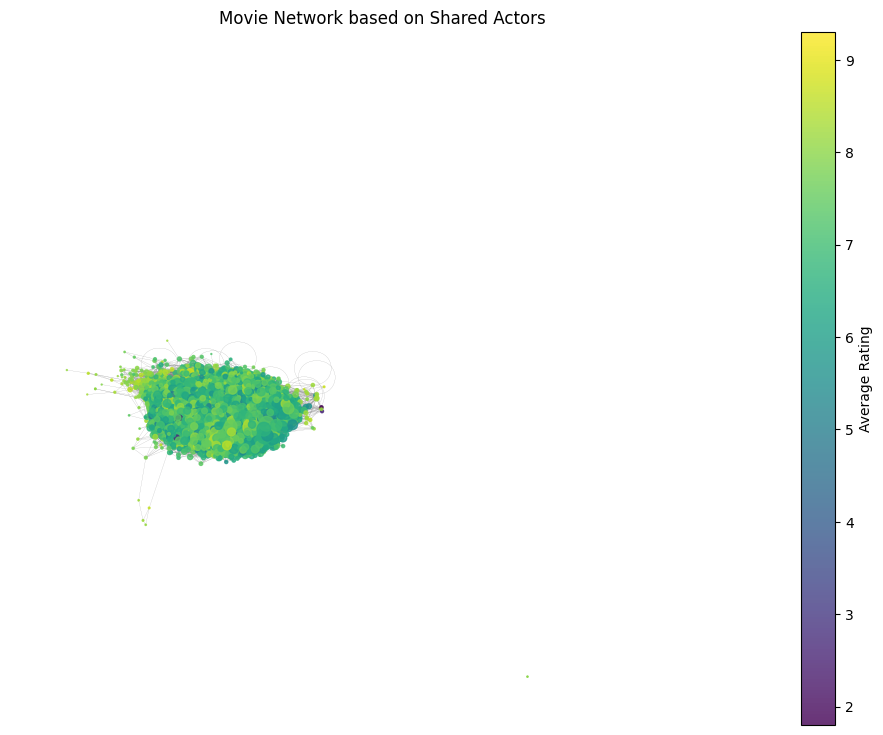

In [28]:
# Ensure nice layout
pos = nx.forceatlas2_layout(G, max_iter=500, jitter_tolerance=0.5, scaling_ratio=1.0, gravity=0.0, seed=seed)

# Dict of degrees for node sizes
degrees = dict(G.degree())
node_sizes = [degrees[node] / 2 for node in G.nodes()]

# Color nodes by average rating
avg_ratings = list(nx.get_node_attributes(G, 'avg_rating').values())

plt.figure(figsize=(12, 9))
# Draw nodes
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=avg_ratings, cmap=plt.cm.viridis, alpha=0.8)
# Draw edges
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.1)

plt.colorbar(nodes, label='Average Rating')
plt.title('Movie Network based on Shared Actors')
plt.axis('off')
plt.show()